In [1]:
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import itertools
import csv
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from tqdm import tqdm

/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
from smt.sampling_methods import LHS
def latin_sampling(num):
    xlimits = np.array([[0,1.0]]*1)
    sampling = LHS(xlimits=xlimits,)
    x = sampling(num)
    return x

In [3]:
def seq_to_oh(sequence):
    onehot=[]
    diction =[['A'], ['C'], ['G'], ['T']]
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(diction)
    for i in range(len(sequence)): 
        sep_seq=list(sequence[i])
        sep_seq=np.array(sep_seq)
        sep_seq=sep_seq.reshape(len(sequence[i]),1)
        A=enc.transform(sep_seq).toarray()
        A=A.reshape(len(sequence[i])*4)
        onehot.append(A)
    onehot=np.array(onehot)
    onehot = onehot.astype('float32')
    return onehot

In [11]:
from sklearn.preprocessing import OneHotEncoder
def Bionehot(sequence): #sequence matrix should be 2d array (num_seq, 1)
    bionehot=[]
    diction =[['A'], ['T'], ['C'], ['G']]
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(diction)
    for i in range(sequence.shape[0]): 
        sep_seq=list(sequence[i][0])
        sep_seq=np.array(sep_seq)
        sep_seq=sep_seq.reshape(10,1)
        A=enc.transform(sep_seq).toarray()
        A=A.reshape(10*4)
        bionehot.append(A)
    bionehot=np.array(bionehot)
    return bionehot

In [ ]:
R2_2000=[]
for i in range(4):
    r2_replicates=[]
    for j in tqdm(range(5)):
        df = pd.read_csv('NK'+str(i)+'.csv')
        def NK_surrogate(input):
            genotype_to_phenotype = dict(zip(df['Genotype'], df['Phenotype']))
            ordered_phenotypes = [genotype_to_phenotype.get(genotype) for genotype in input]
            return np.array(ordered_phenotypes)
        subset_df = df.sample(n=4000)
        data_train, data_test = train_test_split(subset_df, test_size=0.5, random_state=42)
        ## Load initial sampling data for model training - get a fixed model on LHS data
        with open('initial_LHS_2000.txt', 'r') as f:
            initial_sampling=json.load(f)
            data_train=initial_sampling[:2000]
        X_train = seq_to_oh(data_train) 
        y_train = NK_surrogate(data_train)
        X_test = Bionehot(data_test.iloc[:, 0].values.reshape(-1, 1))
        y_test = data_test.iloc[:, 1].values


        mlp = MLPRegressor(random_state=1, max_iter=500)  
        mlp.fit(X_train, y_train)

        y_pred = mlp.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_replicates.append(r2)
    R2_2000.append(r2_replicates)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [19]:
R2_2000

[[0.3679818920754241,
  0.3882193648200657,
  0.3883229701735802,
  0.400918104782517,
  0.38822197841362505],
 [0.2943082599355442,
  0.2949597059544542,
  0.25472111488113525,
  0.2849108393009965,
  0.292356470025665],
 [0.1256542906747261,
  0.16189864860525038,
  0.07643095680514944,
  0.1346803622205378,
  0.13773517886752307],
 [-0.24398903544326878,
  -0.31595886935001793,
  -0.30793276802005054,
  -0.2988083774732242,
  -0.29712218519827416]]

In [ ]:
np.save('R2_2000_LHS.npy', R2_2000)

In [ ]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

R2_2000_ho = []
for i in range(4):
    r2_replicates = []
    for j in tqdm(range(5)):
        df = pd.read_csv('NK' + str(i) + '.csv')

        def NK_surrogate(input):
            genotype_to_phenotype = dict(zip(df['Genotype'], df['Phenotype']))
            ordered_phenotypes = [genotype_to_phenotype.get(genotype) for genotype in input]
            return np.array(ordered_phenotypes)

        subset_df = df.sample(n=4000)
        data_train, data_test = train_test_split(subset_df, test_size=0.5, random_state=42)
        with open('initial_LHS_2000.txt', 'r') as f:
            initial_sampling = json.load(f)
            data_train = initial_sampling[:2000]
        X_train = seq_to_oh(data_train)  # Reshape for a single feature
        y_train = NK_surrogate(data_train)
        X_test = Bionehot(data_test.iloc[:, 0].values.reshape(-1, 1))
        y_test = data_test.iloc[:, 1].values

        # Define the parameter grid
        param_grid = {
            'hidden_layer_sizes': [
                (10,),
                (40, 10),
                (100, 100, 20),
                (10, 100, 100, 20)
            ]
        }
        mlp = MLPRegressor(random_state=1, max_iter=500)
        grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=10, verbose=2)
        grid_search.fit(X_train, y_train)

        # Step 3: Evaluate the Best Model
        best_mlp = grid_search.best_estimator_
        y_pred = best_mlp.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_replicates.append(r2)
    R2_2000_ho.append(r2_replicates)

In [18]:
R2_2000_ho

[[0.8570973318527089,
  0.8599371112226568,
  0.8592932304071033,
  0.8574269135101221,
  0.858059481356677],
 [0.5211547441987446,
  0.5268921984561503,
  0.51001094889558,
  0.5393195544249747,
  0.5277696032582093],
 [0.33939527295354877,
  0.32652925295965185,
  0.3318099335275434,
  0.30849051080282686,
  0.32762616335772177],
 [-0.08912647919932848,
  -0.07750064253943378,
  -0.09258038735029861,
  -0.1213773392552584,
  -0.0819005745771122]]

In [ ]:
np.save('R2_2000_ho.npy', R2_2000_ho)

In [3]:
R2_2000 = np.load('R2_2000_LHS.npy')
R2_2000_ho = np.load('R2_2000_ho.npy')

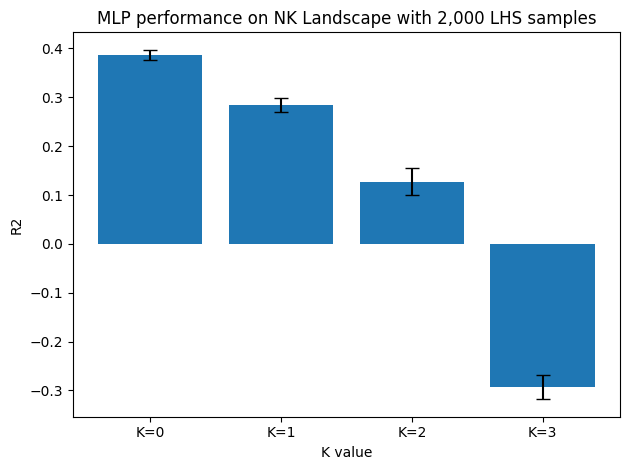

In [7]:
import matplotlib.pyplot as plt
means = np.mean(R2_2000, axis=1)

# Step 2: Calculate the Standard Error (SE = std / sqrt(N))
standard_errors = np.std(R2_2000, axis=1) 

# Step 3: Plot the Bar Chart
x = np.arange(len(means))  # the label locations
plt.bar(x, means, yerr=standard_errors, capsize=5)
plt.xlabel('K value')
plt.ylabel('R2')

plt.title('MLP performance on NK Landscape with 2,000 LHS samples')
plt.xticks(x, [f'K={i}' for i in range(len(means))])
plt.tight_layout()
plt.savefig('MLP_2000.pdf')
plt.show()

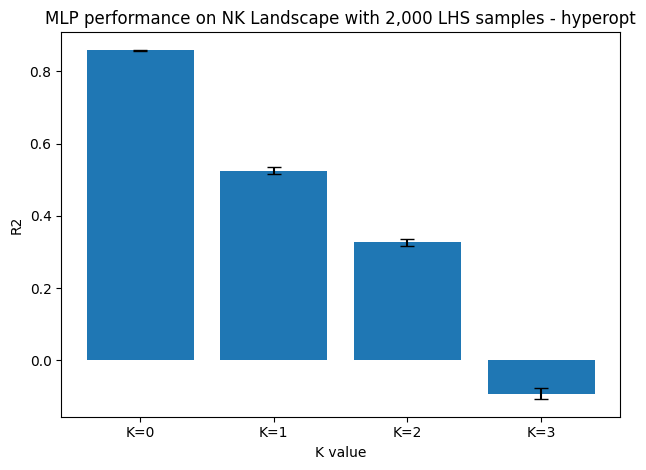

In [8]:
import matplotlib.pyplot as plt
means = np.mean(R2_2000_ho, axis=1)

# Step 2: Calculate the Standard Error (SE = std / sqrt(N))
standard_errors = np.std(R2_2000_ho, axis=1) 

# Step 3: Plot the Bar Chart
x = np.arange(len(means))  # the label locations
plt.bar(x, means, yerr=standard_errors, capsize=5)
plt.xlabel('K value')
plt.ylabel('R2')

plt.title('MLP performance on NK Landscape with 2,000 LHS samples - hyperopt')
plt.xticks(x, [f'K={i}' for i in range(len(means))])
plt.tight_layout()
plt.savefig('MLP_2000_ho.pdf')
plt.show()

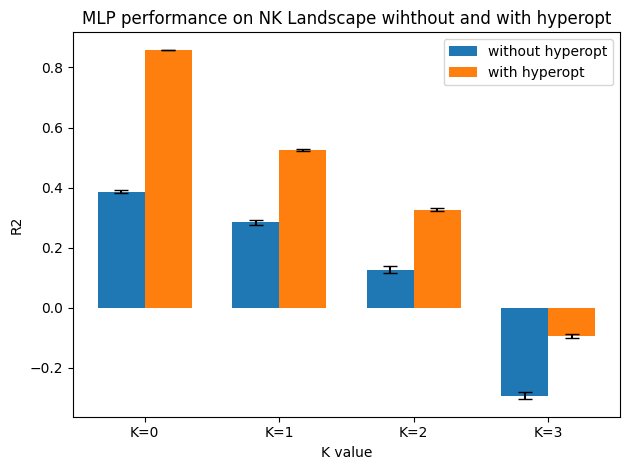

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming R2_2000 and R2_3000 are your two data sources
means_2000 = np.mean(R2_2000, axis=1)
standard_errors_2000 = np.std(R2_2000, axis=1) / np.sqrt(R2_2000.shape[1])

means_3000 = np.mean(R2_2000_ho, axis=1)
standard_errors_3000 = np.std(R2_2000_ho, axis=1) / np.sqrt(R2_2000_ho.shape[1])

x = np.arange(len(means_2000))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_2000, width, yerr=standard_errors_2000, capsize=5, label='without hyperopt')
rects2 = ax.bar(x + width/2, means_3000, width, yerr=standard_errors_3000, capsize=5, label='with hyperopt')

ax.set_xlabel('K value')
ax.set_ylabel('R2')
ax.set_title('MLP performance on NK Landscape wihthout and with hyperopt')
ax.set_xticks(x)
ax.set_xticklabels([f'K={i}' for i in range(len(means_2000))])
ax.legend()

fig.tight_layout()
plt.savefig('MLP_ho.pdf')
plt.show()